<a href="https://colab.research.google.com/github/ChengAng2001/archivedjupyternotebooks/blob/main/XGboost_on_PSAll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sys 
import os
import time
from copy import deepcopy
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import model_selection
from sklearn.metrics.pairwise import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
original_data = pd.read_csv('/content/drive/MyDrive/FairMachineLearning/data/PSDataFrame.csv')
original_overdose_data_with_original_index = pd.read_csv('/content/drive/MyDrive/FairMachineLearning/data/PSAllCnty_SelectedByOverdose.csv')
original_overdose_data = original_overdose_data_with_original_index.drop('Original_index',axis=1)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5,20,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
original_data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
original_overdose_data_with_original_index.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
original_overdose_data.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)

In [5]:
original_no_overdose_data = original_data[~original_data.index.isin(original_overdose_data_with_original_index['Original_index'])]

In [6]:
def data_split(data_set):
  x, validation = model_selection.train_test_split(data_set, test_size=0.2)
  train, test = model_selection.train_test_split(x, test_size=0.125)
  return train, validation, test

In [7]:
train_unbalanced_class_0, validation_unbalanced_class_0, test_unbalanced_class_0 = data_split(original_no_overdose_data)
train_unbalanced_class_1, validation_unbalanced_class_1, test_unbalanced_class_1 = data_split(original_overdose_data)

In [ ]:
'''
train_unbalanced_class_0_x = train_unbalanced_class_0.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code']).sample(n=2000)
train_unbalanced_class_0_y = pd.DataFrame(np.zeros(len(train_unbalanced_class_0_x),dtype=int))

validation_unbalanced_class_0_x = validation_unbalanced_class_0.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code']).sample(n=2000)
validation_unbalanced_class_0_y = pd.DataFrame(np.zeros(len(validation_unbalanced_class_0_x),dtype=int))

test_unbalanced_class_0_x = test_unbalanced_class_0.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code']).sample(n=2000)
test_unbalanced_class_0_y = pd.DataFrame(np.zeros(len(test_unbalanced_class_0_x),dtype=int))

train_unbalanced_class_1_x = train_unbalanced_class_1.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code'])
train_unbalanced_class_1_y = pd.DataFrame(np.ones(len(train_unbalanced_class_1_x),dtype=int))

validation_unbalanced_class_1_x = validation_unbalanced_class_1.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code'])
validation_unbalanced_class_1_y = pd.DataFrame(np.ones(len(validation_unbalanced_class_1_x),dtype=int))

test_unbalanced_class_1_x = test_unbalanced_class_1.drop(columns=['Underlying_Cause_ICD-10_code','Multiple_Conditions_Entity-Axis_conditions_The_conditions','Multiple_Conditions_Record-Axis_conditions_The_conditions','Other_medical_items_Injury_at_work','Other_medical_items_Place_of_injury','Other_medical_items_Activity_code'])
test_unbalanced_class_1_y = pd.DataFrame(np.ones(len(test_unbalanced_class_1_x),dtype=int))
'''

In [ ]:
train_x=pd.concat([train_unbalanced_class_0_x,train_unbalanced_class_1_x])
train_y=pd.concat([train_unbalanced_class_0_y,train_unbalanced_class_1_y])
validation_x=pd.concat([validation_unbalanced_class_0_x,validation_unbalanced_class_1_x])
validation_y=pd.concat([validation_unbalanced_class_0_y,validation_unbalanced_class_1_y])
test_x=pd.concat([test_unbalanced_class_0_x,test_unbalanced_class_1_x])
test_y=pd.concat([test_unbalanced_class_0_y,test_unbalanced_class_1_y])

In [ ]:
numerical_features = [x for x in train_x.columns if train_x[x].dtype == float]
category_features = [x for x in train_x.columns if train_x[x].dtype != float]

In [ ]:
category_features

In [ ]:
def get_mapfunction(x):
    mapp = dict(zip(x.unique().tolist(),
         range(len(x.unique().tolist()))))
    def mapfunction(y):
        if y in mapp:
            return mapp[y]
        else:
            return -1
    return mapfunction
train_x_hashed=deepcopy(train_x)
validation_x_hashed=deepcopy(validation_x)
test_x_hashed=deepcopy(test_x)

for i in category_features:
    train_x_hashed[i] = train_x[i].apply(get_mapfunction(train_x[i]))
    validation_x_hashed[i] = validation_x[i].apply(get_mapfunction(validation_x[i]))
    test_x_hashed[i] = test_x[i].apply(get_mapfunction(test_x[i]))

In [ ]:
train_x

In [ ]:
train_x_hashed

In [ ]:
norm_train_x = normalize(train_x_hashed)
norm_validation_x = normalize(validation_x_hashed)
norm_test_x = normalize(validation_x_hashed)

In [ ]:
train_x_hashed

,General_Record_Type,General_Resident_status,General_Place_of_death_and_decedents_status,General_Day_of_week_of_death,General_Data_year,General_Manner_of_death,Occurrence_State(FIPS),Occurrence_County(FIPS),Occurrence_Expanded_State,Occurrence_County_Population_size,...,Underlying_Cause_113_cause_recode,Underlying_Cause_130_cause_recode,Underlying_Cause_39_cause_recode,Multiple_Conditions_Entity-Axis_conditions_Number_of,Multiple_Conditions_Record-Axis_conditions_Number_of,Other_medical_items_Method_of_disposition,Other_medical_items_Autopsy,Other_medical_items_Certifier,Other_medical_items_Tobacco_use,Other_medical_items_Pregnancy_status
20753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54464,0,0,0,1,1,0,0,1,0,0,...,1,0,0,1,1,0,0,0,0,1
64488,1,1,1,1,2,0,1,2,1,1,...,2,0,1,2,2,1,1,1,1,1
280562,1,1,0,2,3,0,0,3,0,0,...,3,0,2,0,1,1,0,1,2,1
166495,0,0,0,3,4,0,0,4,0,2,...,4,0,0,3,3,2,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,1,1,2,5,7,4,0,76,0,4,...,82,0,11,0,0,2,2,3,1,1
43,1,1,2,0,0,0,0,68,0,4,...,82,0,11,1,1,0,2,0,0,1
668,1,1,2,6,7,4,0,28,0,3,...,82,0,11,1,1,1,2,3,1,1
663,0,0,2,2,7,4,0,10,0,5,...,82,0,11,5,1,2,2,3,1,1


In [ ]:
norm_train_x

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 92.81%


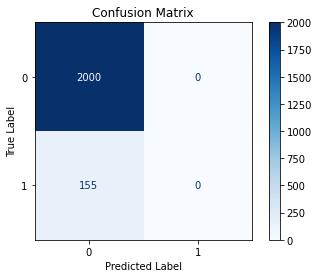

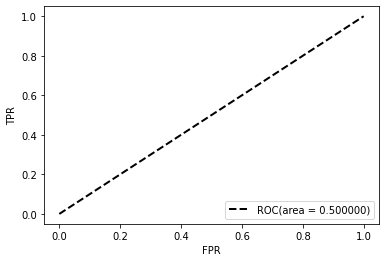

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.46403712296983757
0.5


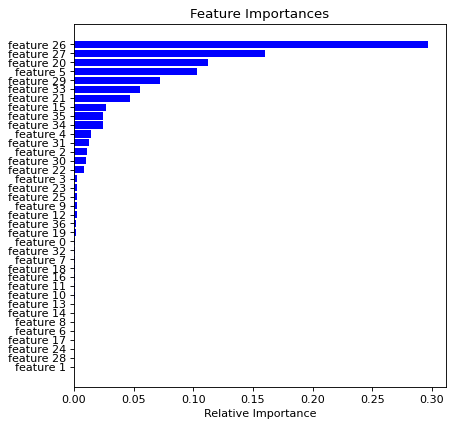

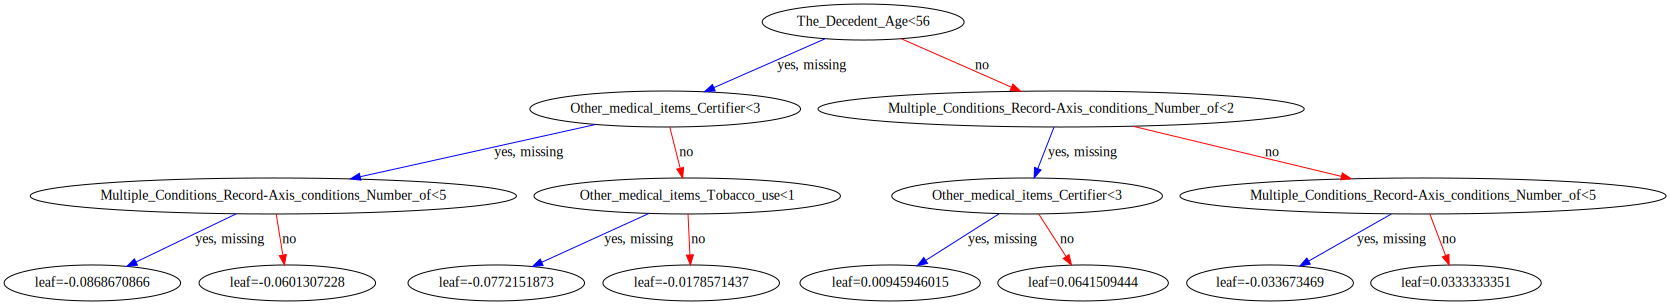

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=2, random_state=30)

xgb_model.fit(train_x_hashed, train_y)

# make predictions for test data
y_pred = xgb_model.predict(validation_x_hashed)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(validation_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

color = 'black'
matrix = plot_confusion_matrix(xgb_model, validation_x_hashed, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()



fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()



print(precision_score(validation_y, y_pred, average='macro'))
print(recall_score(validation_y, y_pred, average='macro'))



figure(figsize=(6, 6), dpi=80)

features = [f"feature {i}" for i in range(train_x_hashed.shape[1])]
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



xgb.to_graphviz(xgb_model)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 99.12%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


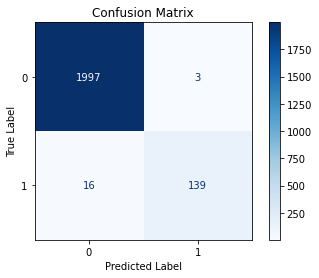

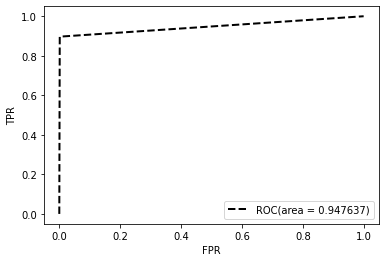

0.9854624518097157
0.9476370967741936


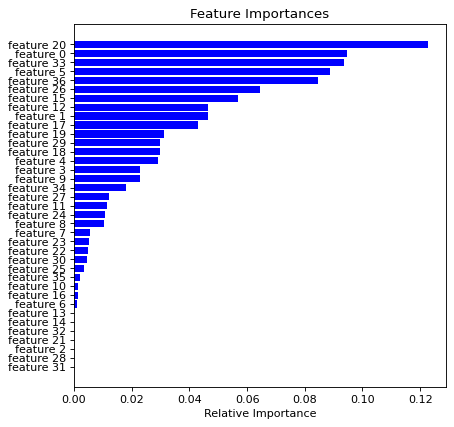

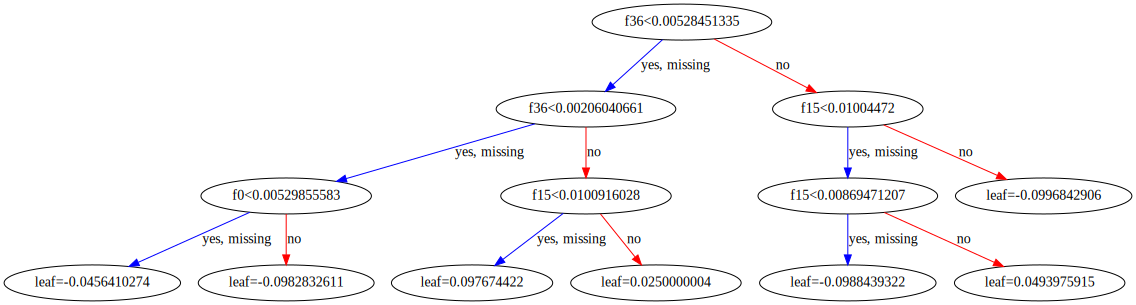

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=2, random_state=30)

xgb_model.fit(norm_train_x, train_y)

# make predictions for test data
y_pred = xgb_model.predict(norm_validation_x)
predictions = [round(value) for value in y_pred]

accuracy = metrics.accuracy_score(validation_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

color = 'black'
matrix = plot_confusion_matrix(xgb_model, norm_validation_x, validation_y, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()



fpr = dict()
tpr = dict()
roc_auc = dict()
lw = 2
fpr, tpr, thresholds = roc_curve(validation_y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'k--', label = 'ROC(area = {0:2f})'.format(roc_auc), lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc = 'lower right')
plt.show()



print(precision_score(validation_y, y_pred, average='macro'))
print(recall_score(validation_y, y_pred, average='macro'))



figure(figsize=(6, 6), dpi=80)

features = [f"feature {i}" for i in range(norm_train_x.shape[1])]
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



xgb.to_graphviz(xgb_model)

In [ ]:
train_x.iloc[: , 20:21]
train_x.iloc[: , 33:34]

,General_Record_Type
20753,2
54464,2
64488,1
280562,1
166495,2
...,...
678,1
43,1
668,1
663,2
